# Climatologies with NWM

In [ ]:
%load_ext watermark

import flox  # make sure its available
import fsspec
import numpy as np
import rioxarray
import xarray as xr

xr.set_options(
    display_expand_attrs=False,
    display_expand_coords=False,
    display_expand_data=True,
)

%watermark -iv

In [ ]:
ds = xr.open_zarr(
    fsspec.get_mapper("s3://noaa-nwm-retrospective-2-1-zarr-pds/rtout.zarr", anon=True),
    consolidated=True,
)
subset = ds.zwattablrt.sel(time=slice("2001", "2005"))
subset

In [44]:
subset

<xarray.DataArray 'zwattablrt' (time: 14608, y: 15360, x: 18432)> Size: 33TB
dask.array<getitem, shape=(14608, 15360, 18432), dtype=float64, chunksize=(224, 350, 350), chunktype=numpy.ndarray>
Coordinates: (3)
Attributes: (4)

### 1. Tree reduction across all groups

In [61]:
mean_mapreduce = subset.groupby("time.month").mean(method="map-reduce")
mean_mapreduce

<xarray.DataArray 'zwattablrt' (month: 12, y: 15360, x: 18432)> Size: 27GB
dask.array<transpose, shape=(12, 15360, 18432), dtype=float64, chunksize=(12, 350, 350), chunktype=numpy.ndarray>
Coordinates: (3)
Attributes: (4)

### 2. "Cohorts"

Loops over month, and tree-reduces each group separately

In [60]:
mean_cohorts = subset.groupby("time.month").mean()
mean_cohorts

<xarray.DataArray 'zwattablrt' (month: 12, y: 15360, x: 18432)> Size: 27GB
dask.array<transpose, shape=(12, 15360, 18432), dtype=float64, chunksize=(1, 350, 350), chunktype=numpy.ndarray>
Coordinates: (3)
Attributes: (4)

### Rechunk, then cohorts

Added some rechunking with the hopes that it makes (2) better.

It does not.

In [65]:
from xarray.groupers import TimeResampler

subset.chunk(time=TimeResampler("ME"))

<xarray.DataArray 'zwattablrt' (time: 14608, y: 15360, x: 18432)> Size: 33TB
dask.array<rechunk-merge, shape=(14608, 15360, 18432), dtype=float64, chunksize=(248, 350, 350), chunktype=numpy.ndarray>
Coordinates: (3)
Attributes: (4)

In [57]:
mean_rechunked_cohorts = subset.chunk(time=TimeResampler("ME")).groupby("time.month").mean()
mean_rechunked_cohorts

<xarray.DataArray 'zwattablrt' (month: 12, y: 15360, x: 18432)> Size: 27GB
dask.array<transpose, shape=(12, 15360, 18432), dtype=float64, chunksize=(2, 350, 350), chunktype=numpy.ndarray>
Coordinates: (3)
Attributes: (4)

## Cluster

In [54]:
import coiled

cluster = coiled.Cluster(n_workers=2, backend_options={"region_name": "us-east-1"})
cluster.adapt(minimum=10, maximum=200)
client = cluster.get_client()

Output()

Output()

2024-08-02 20:30:01,929 - distributed.deploy.adaptive - INFO - Adaptive scaling started: minimum=10 maximum=200


In [55]:
cluster.scale(200)

Turning off adaptive scaling because `scale(n=200)` was explicitly called.
To resume adaptive scaling, you can use the `adapt(minimum=..., maximum=...)` method.
2024-08-02 20:30:02,972 - distributed.deploy.adaptive_core - INFO - Adaptive stop


In [56]:
cluster.wait_for_workers(190)

## Compute

In [35]:
from distributed.diagnostics import MemorySampler

ms = MemorySampler()

In [36]:
from distributed import wait

In [37]:
with ms.sample("map-reduce"):
    wait(mean_mapreduce.persist())

In [38]:
with ms.sample("cohorts"):
    wait(mean_cohorts.persist())

/Users/deepak/miniforge3/envs/coiled/lib/python3.11/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 52.28 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [39]:
with ms.sample("rechunked-cohorts"):
    wait(mean_rechunked_cohorts.persist())

/Users/deepak/miniforge3/envs/coiled/lib/python3.11/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 68.30 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


<Axes: xlabel='time', ylabel='Cluster memory (GiB)'>

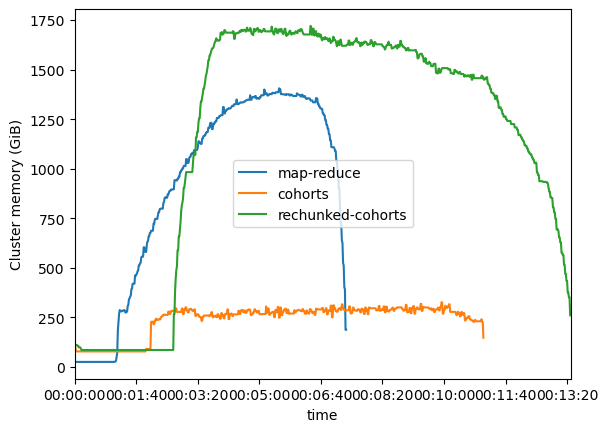

In [47]:
ms.plot(align=True)

## Try rechunking

but to a coarser frequency - 2ME.

In [62]:
mean_rechunked_cohorts2 = subset.chunk(time=TimeResampler("ME")).groupby("time.month").mean()
mean_rechunked_cohorts2

<xarray.DataArray 'zwattablrt' (month: 12, y: 15360, x: 18432)> Size: 27GB
dask.array<transpose, shape=(12, 15360, 18432), dtype=float64, chunksize=(1, 350, 350), chunktype=numpy.ndarray>
Coordinates: (3)
Attributes: (4)

In [58]:
with ms.sample("rechunked-cohorts-2ME"):
    wait(mean_rechunked_cohorts2.persist())

/Users/deepak/miniforge3/envs/coiled/lib/python3.11/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 49.31 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [41]:
cluster.close()

2024-08-02 17:43:35,123 - distributed.deploy.adaptive_core - INFO - Adaptive stop
2024-08-02 17:43:35,304 - distributed.deploy.adaptive_core - INFO - Adaptive stop


<Axes: xlabel='time', ylabel='Cluster memory (GiB)'>

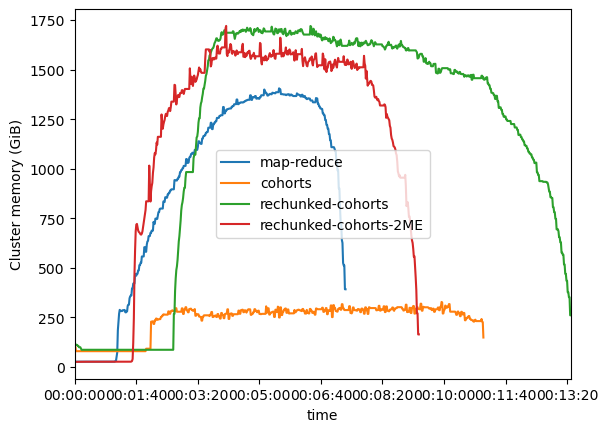

In [59]:
ms.plot(align=True)